# DeepAtlas

https://arxiv.org/abs/1904.08465

In [1]:
import monai
import torch
import glob
import os.path
import numpy as np
import random
import matplotlib.pyplot as plt

# Loading OASIS images

See [fact sheet here](https://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf) for info on OASIS-1 dataset. Get [data here](https://www.oasis-brains.org/#data).

## Filepaths

We already have a segmentaton for each image. These segmentations were originally done by an algorithm:

*Segmentation of brain MR images through a hidden Markov random field model and the expectation maximization algorithm*\
2001 Zhang, Brady, Smith\
[link](https://pubmed.ncbi.nlm.nih.gov/11293691/)

The situation in which we'd want to apply DeepAtlas is one where we have just a handful of carefully created manual segmengations. We will simulate this situation by pretending that some of the segmentation labels don't exist, and ignoring the fact that the segmentations we have come from an algorithm.

In [2]:
oasis_dir = "/data/ebrahim-data/OASIS-1/"
image_paths = glob.glob(os.path.join(oasis_dir,'*/PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img'))
segmentation_paths = glob.glob(os.path.join(oasis_dir,'*/FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img'))

In [3]:
path_to_id = lambda path : os.path.basename(path).strip('OAS1_')[:4]

seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, image_paths)
data = []
for img_index,img_id in enumerate(img_ids):
    seg_index = seg_ids.index(img_id) if (img_id in seg_ids) else None
    seg_path = segmentation_paths[seg_index] if (seg_index is not None) else None
    img_path = image_paths[img_index]
    data.append(
        {
            'img' : img_path,
             'seg' : seg_path
        }
    )

We pretend that only a few segmentations are available.
For all but a few items in `data`, we remove the `seg` key.

Having partially available keys can be handled nicely by transforms
if we set `allow_missing_keys=True` in the transform parameters.
That will come up later when we set up transforms.

In [4]:
num_segs_to_select = 17
random.shuffle(data)
for image_label_dict in data[:(len(data)-num_segs_to_select)]:
    image_label_dict.pop('seg')
random.shuffle(data)

In [5]:
def preview_image(image_array, normalize_by = "volume", cmap = None, figsize = (12,12), threshold = None):
    """
    Display three orthogonal slices of the given 3D image.
    
    image_array is assumed to be of shape (L,W,H)
    
    if a number is provided for threshold, then pixels for which the value
    is below the threshold will be colored red
    """
    if normalize_by == "slice" :
        vmin = None
        vmax = None
    elif normalize_by == "volume" :
        vmin = 0
        vmax = image_array.max().item()
    else :
        raise(ValueError(f"Invalid value '{normalize_by}' given for normalize_by"))
    
    # half-way slices
    x,y,z = np.array(image_array.shape)//2
    imgs = (image_array[x,:,:], image_array[:,y,:], image_array[:,:,z])
    
    fig, axs = plt.subplots(1,3,figsize=figsize)
    for ax,im in zip(axs,imgs):
        ax.axis('off')
        ax.imshow(im, origin = 'lower', vmin = vmin, vmax = vmax, cmap=cmap)
        
        # threshold will be useful when displaying jacobian determinant images;
        # we will want to clearly see where the jacobian determinant is negative
        if threshold is not None:
            red = np.zeros(im.shape+(4,)) # RGBA array
            red[im<=threshold] = [1,0,0,1]
            ax.imshow(red, origin = 'lower')
        
    plt.show()

# Uncomment the following to preview a random image
# preview_image(monai.transforms.LoadImage(image_only=True, reader='itkreader')(random.choice(data)['img']), figsize=(6,6),  normalize_by="slice")

## Datasets for segmentation network pretraining

In the DeepAtlas framework, one jointly or alternatively trains a registration network and a segmentation network. It is recommended that the segmentation network be pre-trained first, using whatever little segmentation is available.

We select the subset of `data` that has segmentation labels available, and then split that into a training and a validation set. 

In [6]:
data_seg_available  =  list(filter(lambda d : 'seg' in d.keys() ,data))
data_seg_unavailable = list(filter(lambda d : 'seg' not in d.keys() ,data))

data_seg_available_train, data_seg_available_valid = \
    monai.data.utils.partition_dataset(data_seg_available, ratios=(8,2))
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. you should definitely skip validation here if there's just one segmentation label.

Now we set up the chain of transforms that will be used to load images and segmentations for the pre-training of the segmentation network.

In [7]:
transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img','seg'], image_only=True),
        monai.transforms.ToTensorD(keys=['img','seg']),
        monai.transforms.TransposeD(keys = ['img', 'seg'], indices = (2,1,0)),
        monai.transforms.AddChannelD(keys=['img','seg']),
        monai.transforms.ResizeD(
            keys = ['img', 'seg'],
            spatial_size=(64,64,64),
            mode = ['trilinear', 'nearest'],
        ), # TODO get rid of resize
    ]
)



# Supress the many warnings related to depracation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
import itk
itk.ProcessObject.SetGlobalWarningDisplay(False)

# "Initializing" ITK by using it a little as in following line
# seems to be necessary to get CacheDataset below to work on the first run.
# Related discussion:
#   https://discourse.itk.org/t/attributeerror-module-itk-itkclassifierspython-has-no-attribute-swig/3168
itk.array_from_image(itk.imread(random.choice(data)['img']));

# Uncomment the following line to preview a random image with the transform above applied
# preview_image(transform_seg_available(random.choice(data_seg_available))['img'][0])

And now we define the datasets that use those transforms to load the data. We use `CacheDataset` to take advantage of MONAI's caching. 

In [8]:
dataset_seg_available_train = monai.data.CacheDataset(
    data = data_seg_available_train,
    transform = transform_seg_available,
    cache_num=8
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data = data_seg_available_valid,
    transform = transform_seg_available,
    cache_num=8
)

Loading dataset: 100%|██████████| 3/3 [00:00<00:00, 61.05it/s]


## Datasets for training both

For the joint/alternative training of the registration and segmentation networks, we want to load _pairs_ of images, along with their segmentation labels when those are available. We create data lists for pairs of images, after reserving some images for validation of the registration network.

In [9]:
# Be careful not to include any images with segmentation label that were used for seg_net validation.
# We don't want those influencing further seg_net training that occurs after pre-training
data_without_seg_valid = data_seg_unavailable + data_seg_available_train # Note the order

# For validation of reg_net, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, # Note the order
    ratios=(2,8), # Note the order
    shuffle = False
)

def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_range = range(len(data)) if symmetric else range(i)
        for j in j_range:
            if j==i: continue
            d1 = data[i]
            d2 = data[j]
            pair = {
                'img1' : d1['img'],
                'img2' : d2['img']
            }
            if 'seg' in d1.keys():
                pair['seg1'] = d1['seg']
            if 'seg' in d2.keys():
                pair['seg2'] = d2['seg']
            data_pairs.append(pair)
    return data_pairs

data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

The variable presence of the `seg1` and `seg2` keys poses a problem for the collation of data into batches.
If we want a batch size greater than 1, then we need to address this.
Our approach is to subdivide the lists of data pairs based on the availability of `seg1` and `seg2`.
The naming convention will be as follows:

| key | segmentation availability |
| ----------- | ----------- |
| `00`      | no segs available |
| `01`   | seg2 available, but no seg1 |
| `10`   | seg1 available, but no seg2 |
| `11`   | both segs available |

In [10]:
def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {'00':[], '01':[], '10':[], '11':[]}
    for d in data_pairs_list:
        if 'seg1' in d.keys() and 'seg2' in d.keys():
            out_dict['11'].append(d)
        elif 'seg1' in d.keys():
            out_dict['10'].append(d)
        elif 'seg2' in d.keys():
            out_dict['01'].append(d)
        else:
            out_dict['00'].append(d)
    return out_dict

data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

In [11]:
# Print some useful counts to be aware of

num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = len(data_pairs_train_subdivided['01']) +\
    len(data_pairs_train_subdivided['10']) +\
    len(data_pairs_train_subdivided['11'])


print(f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone.""")
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

We have 9450 pairs to train reg_net and seg_net together,
  and an additional 109230 to train reg_net alone.
We have 7310 pairs for reg_net validation.


Now we set up the chain of transforms that will be used for loading image pairs.

We will concatenate the "fixed" and "moving" images along the channel dimension.

In [12]:
transform_pair = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img1','seg1', 'img2', 'seg2'], image_only=True,allow_missing_keys=True),
        monai.transforms.ToTensorD(keys=['img1','seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.TransposeD(keys = ['img1','seg1', 'img2', 'seg2'], indices = (2,1,0), allow_missing_keys=True),
        monai.transforms.AddChannelD(keys=['img1','seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0),
        monai.transforms.DeleteItemsD(keys=['img1', 'img2']),
        monai.transforms.ResizeD(
            keys = ['img12', 'seg1', 'seg2'],
            spatial_size=(64,64,64),
            mode = ['trilinear', 'nearest', 'nearest'],
            allow_missing_keys=True
        ), # TODO get rid of resize
    ]
)

And now we define the datasets that use the transforms to load the data. Again we use `CacheDataset` to take advantage of MONAI's caching.

In [13]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI datasets

dataset_pairs_train_subdivided = {
    seg_availability : monai.data.CacheDataset(
        data = data_list,
        transform = transform_pair,
        cache_num=64
    )
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}


dataset_pairs_valid_subdivided = {
    seg_availability : monai.data.CacheDataset(
        data = data_list,
        transform = transform_pair,
        cache_num=64
    )
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset: 100%|██████████| 64/64 [00:01<00:00, 35.69it/s]


# Defining networks and losses


## Segmentation network

In [14]:
# It's not the same as the paper, since the paper does maxpooling for it's seg net,
# while this UNet does convolution with stride>1 for the downsampling steps.
# Also the paper uses leaky relu activation and this uses prelu.
# Also the paper does batch norm while this does instance norm

num_segmentation_classes = 4 # Background, csf, white matter, gray matter

seg_net = monai.networks.nets.UNet(
    3, # spatial dims
    1, # input channels
    num_segmentation_classes, # output channels
    (8,16,16,32,32,64,64), # channel sequence
    (1,2,1,2,1,2), # convolutional strides
    dropout = 0.2,
)

In [15]:
# Try out a forward pass

# It's pretty fortunate that the OASIS images have all their spatial dimensions being multiples of 8,
# cosnidering that we downsample by a factor of 2 three times in the UNet. Very clean.

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item['img'].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg'])}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}") 

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 64, 64, 64])
Shape of seg_net output: torch.Size([1, 4, 64, 64, 64])


## Dice loss for segmentations

In [16]:
dice_loss = monai.losses.DiceLoss(
    include_background=True, # Include background in the multiclass DICE loss: background, CSF, grey, white
    to_onehot_y=True, # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True, # Note that our segmentation network is missing the softmax at the end
    reduction="mean" # Follows the paper
)

# A version of the dice loss with to_onehot_y=False and softmax=False;
# will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False,
    softmax=False,
    reduction="mean"
)

In [17]:
# Uncomment to try out the dice loss on the example.

# dice_loss(
#     seg_net_example_output, # Prediction from seg_net
#     data_item['seg'].unsqueeze(0) # Ground truth label
# )

## Registration network

In [18]:
# Not exactly identical to the registration network in the paper, but similar
# The main difference is that this one doesn't get to the very middle step labeled 1/16
# It seems that MONAI UNet design will not stick one block in the middle like we see in fig 3 of the paper

reg_net = monai.networks.nets.UNet(
    3, # spatial dims
    2, # input channels (one for fixed image and one for moving image)
    3, # output channels (to represent 3D displacement vector field)
    (16,32,32,32,32), # channel sequence
    (1,2,2,2), # convolutional strides
    dropout = 0.2,
)

In [19]:
# Try out a forward pass

def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:],datasets[0])
    return random.choice(datasets_combined)

data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_output = reg_net(data_item['img12'].unsqueeze(0))
print(f"Shape of reg_net output: {reg_net_example_output.shape}") 
# The output of the reg_net is assumed to be a displacement vector field
# (so e.g. a zero output would be the identity warping)

Shape of reg_net output: torch.Size([1, 3, 64, 64, 64])


In [20]:
# For warping segmentation labels or class predictions, we will want to use nearest neighbor interpolation
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="zeros")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="zeros")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item['img12'][[1],:,:,:].unsqueeze(0), # moving image
    reg_net_example_output # warping
)

# Uncomment to preview warped image from forward pass example above
# preview_image(example_warped_image[0,0].detach())

monai.networks.blocks.Warp: Using PyTorch native grid_sample.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


In [21]:
# Preview deformation as a vector field plot

def plot_2D_vector_field(vector_field, downsampling):
    """vector_field should be a tensor of shape (2,L,W).
    The 0 dimension is the two components of the output vectors"""
    downsample2D = monai.networks.layers.factories.Pool['AVG',2](kernel_size=downsampling)
    vf_downsampled = downsample2D(vector_field.unsqueeze(0))[0]
    plt.quiver(vf_downsampled[0,:,:], vf_downsampled[1,:,:]);
    

def preview_3D_vector_field(vector_field, downsampling=None):
    """vector_field should be a tensor of shape (3,L,W,H).
    The 0 dimension is the three components of the output vectors"""
    
    if downsampling is None:
        # guess a reasonable downsampling value to make a nice plot
        downsampling = max(1, int(max(vector_field.shape[1:])) >> 5 )
    
    x,y,z = np.array(vector_field.shape[1:])//2 # half-way slices
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1); plt.axis('off')
    plot_2D_vector_field(vector_field[[1,2],x,:,:], downsampling)
    plt.subplot(1,3,2); plt.axis('off')
    plot_2D_vector_field(vector_field[[0,2],:,y,:], downsampling)
    plt.subplot(1,3,3); plt.axis('off')
    plot_2D_vector_field(vector_field[[0,1],:,:,z], downsampling)
    plt.show()

# Uncomment to preview displacement field from example forward pass of reg_net above
# preview_3D_vector_field(reg_net_example_output.detach()[0])

In [22]:
# The jacobian determinant provides another nice visual of the effect of a warp,
# as well as a way of counting "folds" in the warping.
# Counting folds can help guide us to use more or less regularization during training
def jacobian_determinant(vf):
    """
    Given a displacement vector field vf, compute the jacobian determinant scalar field.
    
    vf is assumed to be a vector field of shape (3,L,W,H),
    and it is interpreted as the displacement field.
    So it is defining a discretely sampled map from a subset of 3-space into 3-space,
    namely the map that sends point (x,y,z) to the point (x,y,z)+vf[:,x,y,z].
    
    Returns a numpy array of shape (L,W,H).
    """

    _, L, W, H = vf.shape
    
    # Compute discrete spatial derivatives
    diff_and_trim = lambda array, axis : np.diff(array, axis=axis)[:,:(L-1),:(W-1),:(H-1)]
    dx = diff_and_trim(vf, 1)
    dy = diff_and_trim(vf, 2)
    dz = diff_and_trim(vf, 3)

    # Add derivative of identity map
    dx[0] += 1
    dy[1] += 1
    dz[2] += 1

    # Compute determinant at each spatial location
    det = dx[0]*(dy[1]*dz[2]-dz[1]*dy[2]) - dy[0]*(dx[1]*dz[2]-dz[1]*dx[2]) + dz[0]*(dx[1]*dy[2]-dy[1]*dx[2])

    return det

## Image similarity loss

In [23]:
# Local normalized cross-correlation loss.
# The paper does a global NCC, but MONAI provides local and it's easy to use.
# Another difference from the paper: instead of returning 1-LNCC this will return -LNCC

lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    ndim=3, # this keyword argument will soon be renamed to spatial_dims
    kernel_size=3,
    kernel_type='rectangular',
    reduction="mean"
)

In [24]:
# Uncomment to try out the image similarity loss on the example.

# lncc_loss(
#     example_warped_image, # registered image
#     data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
# )

## Regularization loss for registration

In [25]:
bending_loss = monai.losses.BendingEnergyLoss()

# Uncomment to try out the bending energy loss on the example
# bending_loss(reg_net_example_output)

# Segmentation network pre-training

In [26]:
dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train,
    batch_size=8,
    num_workers=4,
    shuffle=True
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

Epoch 1/60:
	training loss: 0.779867023229599
	tvalidation loss: 0.706023097038269


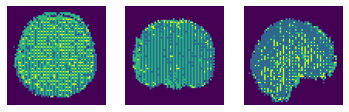

Epoch 2/60:
	training loss: 0.6984367966651917
Epoch 3/60:
	training loss: 0.6393294334411621
Epoch 4/60:
	training loss: 0.5967119634151459
Epoch 5/60:
	training loss: 0.5661733448505402
Epoch 6/60:
	training loss: 0.5434221029281616
	tvalidation loss: 0.5133650302886963


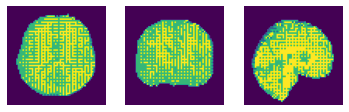

Epoch 7/60:
	training loss: 0.523430585861206
Epoch 8/60:
	training loss: 0.5054700374603271
Epoch 9/60:
	training loss: 0.486964151263237
Epoch 10/60:
	training loss: 0.46814538538455963
Epoch 11/60:
	training loss: 0.45192575454711914
	tvalidation loss: 0.42239877581596375


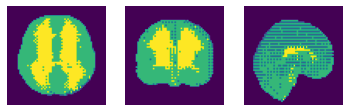

Epoch 12/60:
	training loss: 0.43585972487926483
Epoch 13/60:
	training loss: 0.42020589113235474
Epoch 14/60:
	training loss: 0.4064966142177582
Epoch 15/60:
	training loss: 0.3938301056623459
Epoch 16/60:
	training loss: 0.3813154101371765
	tvalidation loss: 0.3567182421684265


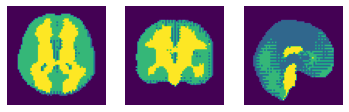

Epoch 17/60:
	training loss: 0.37017206847667694
Epoch 18/60:
	training loss: 0.3593323528766632
Epoch 19/60:
	training loss: 0.35048289597034454
Epoch 20/60:
	training loss: 0.3389490395784378
Epoch 21/60:
	training loss: 0.3299206793308258
	tvalidation loss: 0.30703651905059814


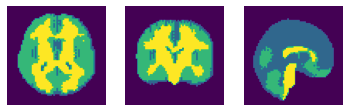

Epoch 22/60:
	training loss: 0.3197776675224304
Epoch 23/60:
	training loss: 0.31102287769317627
Epoch 24/60:
	training loss: 0.3025866448879242
Epoch 25/60:
	training loss: 0.2956641763448715
Epoch 26/60:
	training loss: 0.2908751964569092
	tvalidation loss: 0.2732875347137451


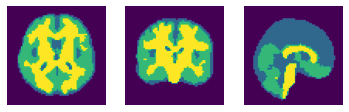

Epoch 27/60:
	training loss: 0.2839680016040802
Epoch 28/60:
	training loss: 0.28023138642311096
Epoch 29/60:
	training loss: 0.27722808718681335
Epoch 30/60:
	training loss: 0.2730025351047516
Epoch 31/60:
	training loss: 0.2697858065366745
	tvalidation loss: 0.25322285294532776


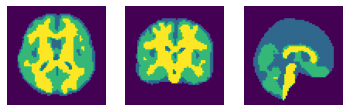

Epoch 32/60:
	training loss: 0.26670506596565247
Epoch 33/60:
	training loss: 0.2630293071269989
Epoch 34/60:
	training loss: 0.26089373230934143
Epoch 35/60:
	training loss: 0.25783437490463257
Epoch 36/60:
	training loss: 0.25635235011577606
	tvalidation loss: 0.23917391896247864


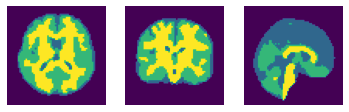

Epoch 37/60:
	training loss: 0.2529221326112747
Epoch 38/60:
	training loss: 0.2506672739982605
Epoch 39/60:
	training loss: 0.24949584156274796
Epoch 40/60:
	training loss: 0.24731087684631348
Epoch 41/60:
	training loss: 0.24557235091924667
	tvalidation loss: 0.22797346115112305


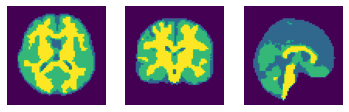

Epoch 42/60:
	training loss: 0.24356258660554886
Epoch 43/60:
	training loss: 0.24010635912418365
Epoch 44/60:
	training loss: 0.23858487606048584
Epoch 45/60:
	training loss: 0.23768723756074905
Epoch 46/60:
	training loss: 0.23650114983320236
	tvalidation loss: 0.21968671679496765


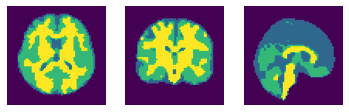

Epoch 47/60:
	training loss: 0.23396195471286774
Epoch 48/60:
	training loss: 0.23220276832580566
Epoch 49/60:
	training loss: 0.23038102686405182
Epoch 50/60:
	training loss: 0.2291586920619011
Epoch 51/60:
	training loss: 0.22788354009389877
	tvalidation loss: 0.2110915184020996


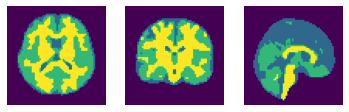

Epoch 52/60:
	training loss: 0.22602340579032898
Epoch 53/60:
	training loss: 0.22559480369091034
Epoch 54/60:
	training loss: 0.22425789386034012
Epoch 55/60:
	training loss: 0.22256676107645035
Epoch 56/60:
	training loss: 0.2221577763557434
	tvalidation loss: 0.20387211441993713


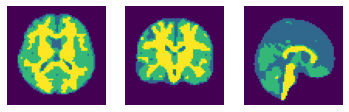

Epoch 57/60:
	training loss: 0.22029852867126465
Epoch 58/60:
	training loss: 0.21798618882894516
Epoch 59/60:
	training loss: 0.21759743243455887
Epoch 60/60:
	training loss: 0.21672511100769043


In [27]:
# Training cell, uncomment when you want to train

seg_net.to('cuda')

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 60
training_losses = []
validation_losses = []
validation_every = 5

for epoch_number in range(max_epochs):
    
    print(f"Epoch {epoch_number+1}/{max_epochs}:")
    
    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])
    
    if epoch_number%validation_every == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].to('cuda')
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\ttvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])
    
        # Uncomment to preview a particular predicted segmentation during training
        preview_image(torch.argmax(torch.softmax(seg_net(dataset_seg_available_valid[0]['img'].unsqueeze(0).cuda()),dim=1),dim=1, keepdim=True)[0,0].cpu(), figsize=(6,6))
    

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

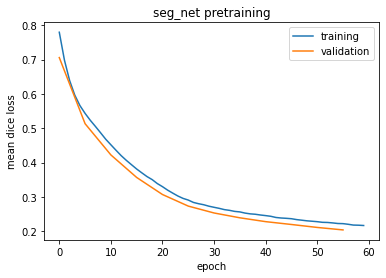

In [28]:
# Plot the training and validation losses

def plot_against_epoch_numbers(epoch_and_value_pairs, **kwargs):
    array = np.array(epoch_and_value_pairs)
    plt.plot(array[:,0], array[:,1], **kwargs)

plot_against_epoch_numbers(training_losses, label="training")
plot_against_epoch_numbers(validation_losses, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean dice loss')
plt.title('seg_net pretraining')
plt.savefig('seg_net_pretrained_losses.png')
plt.show()

In [29]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(),'seg_net_pretrained.pth')

In [30]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net_pretrained.pth'))

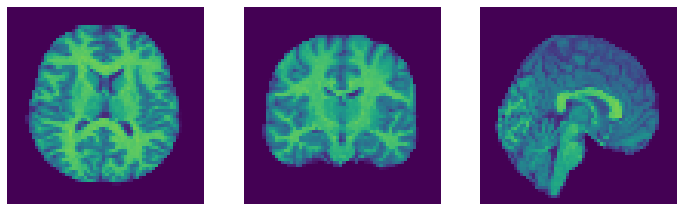

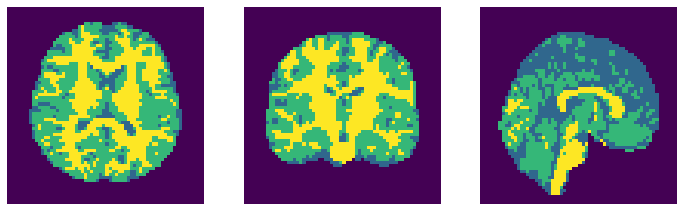

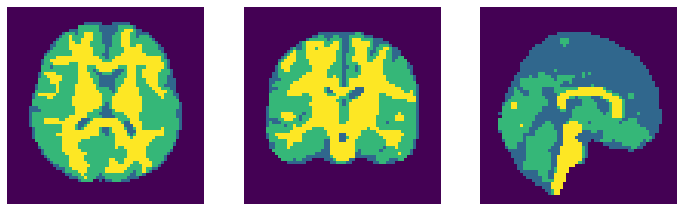

In [31]:
# Uncomment to try out pretrained seg net on one of the validation images

seg_net.to('cuda')

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

# Original image from validation set
preview_image(test_input[0])
# Ground truth segmentation
preview_image(test_seg_true[0])
# Our predicted segmentation
preview_image(torch.argmax(torch.softmax(test_seg_predicted,dim=1),dim=1, keepdim=True)[0,0])

del test_seg_predicted
torch.cuda.empty_cache()

# Training both in alternation

For the sake of being able to fit everything into video memory, we will choose to train the registration and segmentation networks in _alternation_ rather than jointly.

In [32]:
def swap_training(network_to_train, network_to_not_train):
    """
        Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False
    
    for param in network_to_train.parameters():
        param.requires_grad = True
        
    network_to_not_train.eval()
    network_to_train.train()

In [33]:
# Functions to compute the ingredients of the final loss computation for reg_net

regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """ Accepts a batch of displacement fields, shape (B,3,L,W,H)
        and a batch of image pairs, shape (B,2,L,W,H) """
    warped_img2 = warp(image_pair[:,[1],:,:,:], displacement_field)
    return lncc_loss(
        warped_img2, # prediction
        image_pair[:,[0],:,:,:] # target
    )

def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1 = None, gt_seg2 = None):
    """ 
    Accepts a batch of displacement fields, shape (B,3,L,W,H)
    and a batch of image pairs, shape (B,2,L,W,H).
    seg_net is the model used to segment an image,
      mapping (B,1,L,W,H) to (B,C,L,W,H) where C is the number of segmentation classes
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,L,W,H)
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(
            gt_seg1 , num_segmentation_classes
        )
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:,[0],:,:,:]).softmax(dim=1) 

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(
            gt_seg2 , num_segmentation_classes
        )
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:,[1],:,:,:]).softmax(dim=1)

    # seg1 and seg2 should now be in the form of one-hot class probabilities

    return dice_loss2(
        warp_nearest(seg2, displacement_field), # warp of moving image segmentation
        seg1 # target image segmentation
    )

In [34]:
# Function for forward pass of reg_net, to avoid duplicating code between training and validation

def reg_losses(batch):
    img12 = batch['img12'].to('cuda')

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch['seg1'].to('cuda') if 'seg1' in batch.keys() else None
    gt_seg2 = batch['seg2'].to('cuda') if 'seg2' in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana

TODO: Insert explanation of data sampling method that is set up below

In [35]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability : monai.data.DataLoader(
        dataset,
        batch_size=8,
        num_workers=4,
        shuffle=True
    )
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability : monai.data.DataLoader(
        dataset,
        batch_size=16,
        num_workers=4,
        shuffle=True # Weird to shuffle validation data, but makes sense if you just take a small sample each time
                 # (which I've been doing because it would take way too long to go through all validation pairs)
    )
        if len(dataset) > 0 else [] # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

In [36]:
seg_availabilities = ['00', '01', '10', '11']
def create_batch_generator(dataloader_subdivided, weights = None):
    """
    Create a batch generator that samples data pairs with various segmentation label availabilities.
    
    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets
                  
    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and 
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s:iter(d) for s,d in dataloader_subdivided.items()}
    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration: # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] =\
                    iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])
    return batch_generator

In [37]:
batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)


# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0]+[len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(f"""Segmentation availabilities {seg_availabilities}
will be sampled with weights {seg_train_sampling_weights}""")
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Segmentation availabilities ['00', '01', '10', '11']
will be sampled with weights [0, 580, 580, 23]


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desi

TODO: insert some kind of comment about training, how epochs aren't really epochs here

In [ ]:
# Training cell, uncomment when you want to train

seg_net.to('cuda')
reg_net.to('cuda')


# learning_rate_reg = 5e-4
learning_rate_reg = 1e-3
optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

# learning_rate_seg = 1e-4
learning_rate_seg = 1e-3
optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

# Weights of various registration losses, relative to the image similarity loss
lambda_r  = 0.2 # regularization loss weight
lambda_a  = 2.0 # anatomy loss weight
lambda_sp = 3.0 # supervised segmentation loss weight


max_epochs = 40
reg_phase_training_batches_per_epoch = 40
seg_phase_training_batches_per_epoch = 10
reg_phase_num_validation_batches_to_use = 40
validation_every = 5

training_losses_reg = []
validation_losses_reg = []
training_losses_seg = []
validation_losses_seg = []



for epoch_number in range(max_epochs):
    
    print(f"Epoch {epoch_number+1}/{max_epochs}:")
    
    # ------------------------------------------------
    #         reg_net training phase
    # ------------------------------------------------
    
    # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
    swap_training(reg_net, seg_net)
    
    losses = []
    for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
        optimizer_reg.zero_grad()
        loss_sim, loss_reg, loss_ana = reg_losses(batch)
        loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
        loss.backward()
        optimizer_reg.step()
        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"\treg training loss: {training_loss}")
    training_losses_reg.append([epoch_number, training_loss])
    
    if epoch_number%validation_every == 0:
        reg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
                loss_sim, loss_reg, loss_ana = reg_losses(batch)
                loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
                losses.append(loss.item())
            
        validation_loss = np.mean(losses)
        print(f"\treg validation loss: {validation_loss}")
        validation_losses_reg.append([epoch_number, validation_loss])
    
    # Free up memory
    del loss, loss_sim, loss_reg, loss_ana
    torch.cuda.empty_cache()
    
    # ------------------------------------------------
    #         seg_net training phase
    # ------------------------------------------------
    
    # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
    swap_training(seg_net, reg_net)
    
    losses = []
    for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
        optimizer_seg.zero_grad()
        
        img12 = batch['img12'].to('cuda')
        
        displacement_fields = reg_net(img12)
        seg1_predicted = seg_net(img12[:,[0],:,:,:]).softmax(dim=1)
        seg2_predicted = seg_net(img12[:,[1],:,:,:]).softmax(dim=1)
        
        # Below we compute the following:
        # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
        # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
        # loss_metric: a single supervised seg loss, as a metric to track the progress of training 
        
        if 'seg1' in batch.keys() and 'seg2' in batch.keys():
            seg1 = monai.networks.one_hot(batch['seg1'].to('cuda') , num_segmentation_classes)
            seg2 = monai.networks.one_hot(batch['seg2'].to('cuda') , num_segmentation_classes)
            loss_metric = dice_loss2( seg2_predicted , seg2 )
            loss_supervised = dice_loss2( seg1_predicted , seg1 ) + loss_metric
            # The above supervised loss looks a bit different from the one in the paper
            # in that it includes predictions for both images in the current image pair;
            # we might as well do this, since we have gone to the trouble of loading
            # both segmentations into memory.
            
        elif 'seg1' in batch.keys(): # seg1 available, but no seg2
            seg1 = monai.networks.one_hot(batch['seg1'].to('cuda') , num_segmentation_classes)
            loss_metric = dice_loss2( seg1_predicted , seg1 )
            loss_supervised = loss_metric
            seg2 = seg2_predicted # Use this in anatomy loss
        
        else: # seg2 available, but no seg1
            assert('seg2' in batch.keys())
            seg2 = monai.networks.one_hot(batch['seg2'].to('cuda') , num_segmentation_classes)
            loss_metric = dice_loss2( seg2_predicted , seg2 )
            loss_supervised = loss_metric
            seg1 = seg1_predicted # Use this in anatomy loss
            
        # seg1 and seg2 should now be in the form of one-hot class probabilities
        
        loss_anatomy = dice_loss2( warp_nearest(seg2, displacement_fields), seg1 )\
            if 'seg1' in batch.keys() or 'seg2' in batch.keys()\
            else 0. # It wouldn't really be 0, but it would not contribute to training seg_net
        # (If you want to refactor the code for joint training of reg_net and seg_net,
        #  then remove this conditional and compute the anatomy loss in all cases)
            
        
        loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
        loss.backward()
        optimizer_seg.step()

        losses.append(loss_metric.item())
    
    training_loss = np.mean(losses)
    print(f"\tseg training loss: {training_loss}")
    training_losses_seg.append([epoch_number, training_loss])
    
    if epoch_number%validation_every == 0:
        # The following validation loop would not do anything in the case
        # where there is just one segmentation available,
        # because data_seg_available_valid would be empty.
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].to('cuda')
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())
        
        validation_loss = np.mean(losses)
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg.append([epoch_number, validation_loss])
    
    # Free up memory
    del loss, seg1, seg2, displacement_fields, img12, loss_supervised, loss_anatomy, loss_metric,\
        seg1_predicted, seg2_predicted
    torch.cuda.empty_cache()


Epoch 1/40:
	reg training loss: 0.12252524420619011


In [ ]:
# Plot the training and validation losses

plot_against_epoch_numbers(training_losses_reg, label="training")
plot_against_epoch_numbers(validation_losses_reg, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Alternate training: registration loss')
plt.savefig('reg_net_losses.png')
plt.show()

plot_against_epoch_numbers(training_losses_seg, label="training")
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Alternate training: segmentation loss (training)')
plt.savefig('seg_net_training_losses.png')
plt.show()

plot_against_epoch_numbers(validation_losses_seg, label="validation", color='orange')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Alternate training: segmentation loss (validation)')
plt.savefig('seg_net_validation_losses.png')
plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(),'seg_net.pth')
torch.save(reg_net.state_dict(),'reg_net.pth')

In [ ]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net.pth'))
# reg_net.load_state_dict(torch.load('reg_net.pth'))

In [ ]:
# Uncomment to try out reg net on one of the validation pairs

reg_net.to('cuda')
reg_net.eval()

data_item = take_random_from_subdivided_dataset(dataset_pairs_valid_subdivided)
img12 = data_item['img12'].unsqueeze(0).to('cuda')

with torch.no_grad():
    reg_net_example_output = reg_net(img12)

example_warped_image = warp(
    img12[:,[1],:,:,:], # moving image
    reg_net_example_output # warping
)

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0,1,:,:,:].cpu(), normalize_by="slice", cmap='gray')
print("target image:")
preview_image(img12[0,0,:,:,:].cpu(), normalize_by="slice", cmap='gray')
print("warped moving image:")
preview_image(example_warped_image[0,0].cpu(), normalize_by="slice", cmap='gray')
print("deformation field:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])
print("jacobian determinant:")
det = jacobian_determinant(reg_net_example_output.cpu().detach()[0])
preview_image(det, normalize_by='slice', threshold=0)
loss = lncc_loss(example_warped_image,img12[:,[0],:,:,:]).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()

In [ ]:
# Uncomment to try out seg net on one of the validation images

seg_net.to('cuda')

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()
    loss = dice_loss(test_seg_predicted, test_seg_true.unsqueeze(0)).item()

print("original image from validation set:")
preview_image(test_input[0], normalize_by="slice", cmap='gray')
print("ground truth segmentation:")
preview_image(test_seg_true[0])
print("our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted,dim=1),dim=1, keepdim=True)[0,0])
print(f"dice loss: {loss}")

del test_seg_predicted
torch.cuda.empty_cache()

In [ ]:
# Here we evaluate the regularity of reg_net
# by sampling some image pairs from the validation set
# and counting folds

num_batches = 200 # sample this many batches

fold_counts = []
reg_net.eval()
with torch.no_grad():
    for batch in batch_generator_valid_reg(num_batches):
        img12 = batch['img12'].to('cuda')
        displacement_fields = reg_net(img12)
        for displacement_field in displacement_fields:
            det = jacobian_determinant(displacement_field.cpu())
            num_folds = (det <= 0).sum()
            fold_counts.append(num_folds)
        
del img12, displacement_fields
torch.cuda.empty_cache()

plt.hist(fold_counts)
plt.title("Number of folds")
plt.savefig('folds_histogram.png')
plt.show()
print(f"Mean fold count: {np.mean(fold_counts)}")